## NeuroWorkshop

## Object Detection с использованием предобученной сети YOLO

Код в этом ноутбуке заимствован [отсюда](https://github.com/arunponnusamy/object-detection-opencv) и творчески переработан [Дмитрием Сошниковым](http://blog.soshnikov.com)

В этом примере мы используем предобученную сеть YOLO, подготовленную [Arun Ponnusamy](https://github.com/arunponnusamy), и встроенные средства OpenCV для нейросетевого вывода. 

Для начала, необходимо скачать веса нейросети и её конфигурацию:

In [2]:
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg

--2019-03-25 14:09:22--  https://raw.githubusercontent.com/arunponnusamy/object-detection-opencv/master/yolov3.cfg
Resolving webproxy (webproxy)... 10.36.38.1
Connecting to webproxy (webproxy)|10.36.38.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0.007s  

2019-03-25 14:09:23 (1.12 MB/s) - ‘yolov3.cfg’ saved [8342/8342]



In [3]:
!cat yolov3.cfg

[net]
# Testing
# batch=1
# subdivisions=1
# Training
batch=64
subdivisions=16
width=608
height=608
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 500200
policy=steps
steps=400000,450000
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutiona

Нам также понадобится OpenCV:

In [6]:
import sys
!{sys.executable} -m pip install opencv-python

    100% |████████████████████████████████| 25.4MB 50kB/s  eta 0:00:01  5% |█▉                              | 1.4MB 23.1MB/s eta 0:00:02


In [8]:
import cv2
import argparse
import numpy as np
import matplotlib.pyplot as plt

Загружаем изображение, которое мы будем использовать:

In [4]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Girl_and_cat.jpg/1200px-Girl_and_cat.jpg

--2019-03-25 14:12:27--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ab/Girl_and_cat.jpg/1200px-Girl_and_cat.jpg
Resolving webproxy (webproxy)... 10.36.38.1
Connecting to webproxy (webproxy)|10.36.38.1|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 123552 (121K) [image/jpeg]
Saving to: ‘1200px-Girl_and_cat.jpg’

1200px-Girl_and_cat 100%[===================>] 120.66K  --.-KB/s    in 0.07s   

2019-03-25 14:12:27 (1.72 MB/s) - ‘1200px-Girl_and_cat.jpg’ saved [123552/123552]



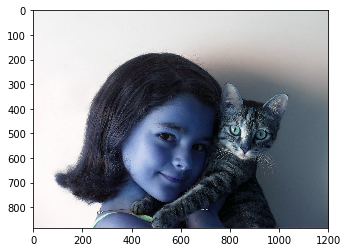

In [33]:
image = cv2.imread('1200px-Girl_and_cat.jpg')
plt.imshow(image)
plt.show()

Теперь загружаем модель:

In [10]:
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

In [15]:
classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [13]:
print(classes)

['', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', '']


Some useful functions:

In [23]:
def get_output_layers(net):    
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), (255,255,0), 6)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 6)

Now, actually run Yolo network on the image:

In [17]:
Width = image.shape[1]
Height = image.shape[0]

blob = cv2.dnn.blobFromImage(image, 1/256, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

print(outs)

[array([[0.0420114 , 0.0288114 , 0.2913806 , ..., 0.        , 0.        ,
        0.        ],
       [0.05949561, 0.04090808, 0.22716238, ..., 0.        , 0.        ,
        0.        ],
       [0.05524378, 0.02115927, 1.0486748 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.96974176, 0.9565612 , 0.4683441 , ..., 0.        , 0.        ,
        0.        ],
       [0.96776325, 0.96460056, 0.31671292, ..., 0.        , 0.        ,
        0.        ],
       [0.96805423, 0.96375585, 0.8228126 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32), array([[0.0251226 , 0.0328715 , 0.05428527, ..., 0.        , 0.        ,
        0.        ],
       [0.02159968, 0.03191785, 0.18031715, ..., 0.        , 0.        ,
        0.        ],
       [0.02699502, 0.02208945, 0.08713992, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.97575086, 0.9801814 , 0.04522295, ..., 0.        , 0.        ,
        0.        ],
       [0.98315006

In [40]:
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.8

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])
            print("Detected {} with confidence={}".format(classes[class_id],confidence))

Detected person with confidence=0.9224553108215332
Detected cat with confidence=0.997937798500061


Нарисуем все найденные bounding boxes:

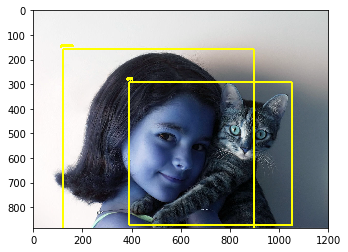

In [41]:
img = image[:]
for cls,box,conf in zip(class_ids,boxes,confidences):
    draw_prediction(img, cls, conf, round(box[0]), round(box[1]), round(box[0]+box[2]), round(box[1]+box[3]))
    
plt.imshow(img)
plt.show()

Для того, чтобы избавиться от повторных box-ов, используется алгоритм Non-maxima suppression (NMS):

In [44]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

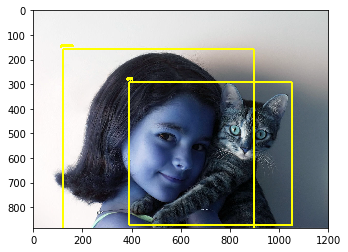

In [45]:
plt.imshow(image)
plt.show()

Наконец, удалим за собой все файлы:

In [46]:
!rm yolov3.* 1200px-Girl_and_cat.jpg